In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Названия столбцов и порядки округления величин

In [ ]:
timestamp = 'timestamp'
ch4_name = 'CH4'
ch4Ref_name = 'CH4Ref'
ch4LR_name = 'CH4LR'
voltage_name = 'V'
adc_name = 'ADC'
T_name = 'T'
rh_name = 'rH'
ah_name = 'aH'
P_name = 'P'
fanspeed_name = 'fanSpeed'
res_header = [timestamp, adc_name, voltage_name, T_name, rh_name, ah_name, P_name, fanspeed_name]
round_order = {adc_name : 0, T_name : 1, rh_name : 1, ah_name : 5, P_name : 1}

Максимальная концентрация ppm для рассмотрения

In [63]:
max_value = 20

Ввести название файла

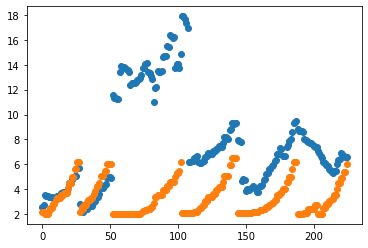

In [66]:
filename = "calculated_with_calibration16_series_24_26_27_29_37.csv"
df = pd.read_csv(filename)
df.timestamp = pd.to_datetime(df.timestamp)
# Временные пределы рассмотрения данных
df.drop(df[df.CH4Ref > max_value].index, inplace=True)
# Интересуемый временной промежуток
condition = ("2022-05-23 10:21:07.348414" < df.timestamp ) &  (df.timestamp < "2022-05-27 22:30:05.348414")
plt.scatter(df.index[condition], df.CH4LR[condition])
plt.scatter(df.index[condition], df.CH4Ref[condition])

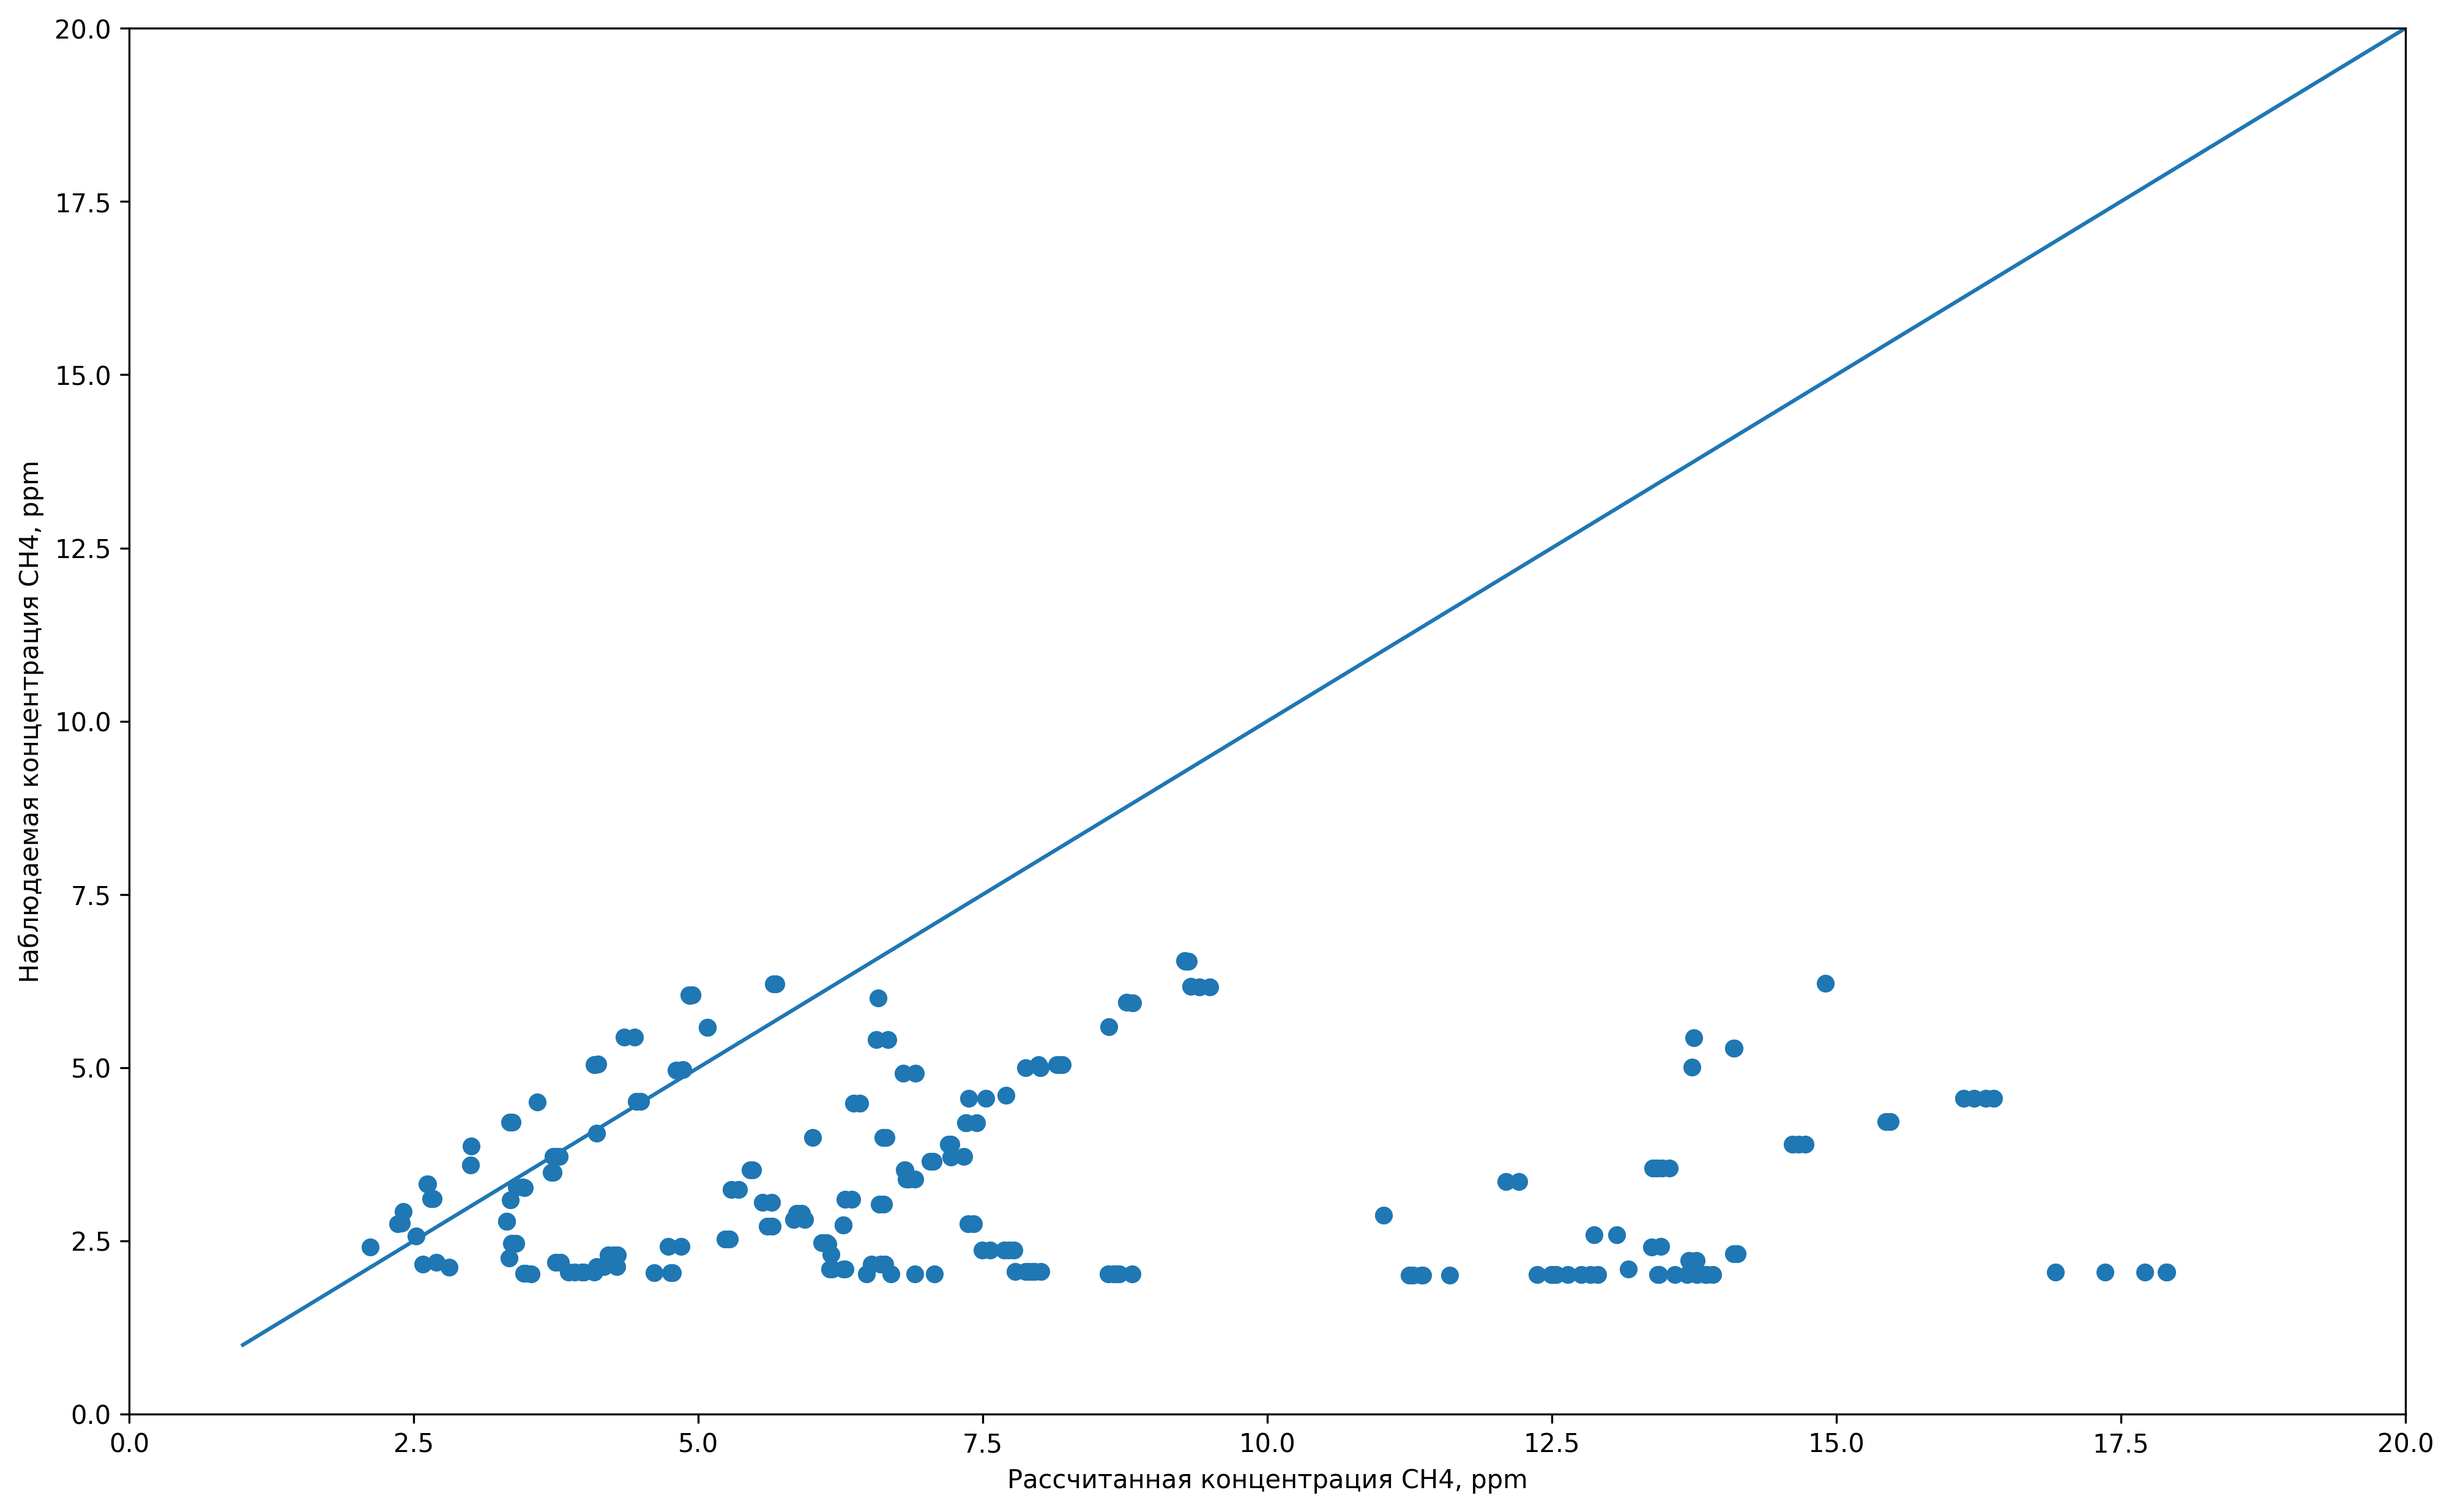

In [67]:
figure, axis = plt.subplots(figsize=(16,10), dpi = 300)
axis.scatter(df.CH4LR[condition], df.CH4Ref[condition])
plt.plot([1,max_value], [1,max_value])
plt.axis([0, max_value, 0 , max_value])
plt.xlabel('Рассчитанная концентрация CH4, ppm')
plt.ylabel('Наблюдаемая концентрация CH4, ppm')

df["variance"] = df.CH4Ref[condition] - df.CH4LR[condition] # ошибка (расхождение) в данных

# Сохранять результаты в файл только при максимальной концентрации
if max_value == 100:
	df=df.round({"variance" : 2})
	df.to_csv(filename, index=False)

figure.savefig(f'obs_vs_predicted_{filename}_lim_{max_value}.png')

Определение количества точек, удовлетворящих условия на величину ошибки

In [61]:
max_variance = 0.1
df[(abs(df.variance) < max_variance)].shape[0]

(7, 14)

Функция для определения RMSE

In [9]:
def rmse(predictions, targets):
    return np.sqrt(sum((predictions - targets) ** 2)/len(predictions))

In [62]:
rmse(df.CH4LR[condition], df.CH4Ref[condition]) # расчет RMSE

6.129585799310679

Построение графика ошибок для различных концентраций

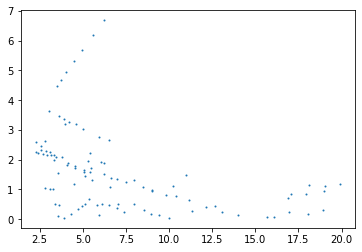

In [178]:
plt.scatter(df.CH4Ref[condition], abs(df.variance[condition]), s = 1)

## Поиск лучшей модели в таблице моделей

Названия столбцов в файле с моделями

In [3]:
model = "Model"
model1 = "V0" + model
model2 = "CH4" + model
model3 = "CH4LR" + model
func_name = "function_name"
predictor_names = "predictor_names"
predictors_count = "predictors_count"
dependent_name = "dependent_name"
coefficients = "coefficients"
rmse = "rmse"
adjusted_r_squared = "adjusted_r_squared"
colV0PredCount = model1 + predictors_count
colCH4PredCount = model2 + predictors_count
colV0rmse =  model1 + rmse
colCH4rmse =  model2 + rmse
colV0r2 =  model1 + adjusted_r_squared
colCH4r2 =  model2 + adjusted_r_squared
colCH4LRr2 =  model3 + adjusted_r_squared
colCH4LRrmse =  model3 + rmse

Поиск лучшей модели в файле df_resultModels по условиям df_conditions

In [75]:
df_resultModels = pd.read_csv("../MS_DATA/ResultModels/models_best6_151210_series_22_23_24_25_26_27_28_29_30_31_37_38.csv")
df_conditions = df_resultModels.loc[(df_resultModels[colV0r2]>0.9) & (df_resultModels[colCH4r2]>0.9) & (df_resultModels[colCH4LRr2]>0.9) & ((df_resultModels[colCH4LRrmse] + df_resultModels[colCH4rmse]) < 2.3)]
df_Func8 = df_conditions
# df_Func8.drop(columns=['Unnamed: 0'], inplace = True)
sort_by = [ colCH4LRrmse, colCH4rmse, colCH4PredCount, colV0PredCount, colCH4r2, colV0r2, colCH4LRr2,   colV0rmse]
asc_desc = [True, True, True, True, False, False, False, True]
df_sorted = df_Func8.sort_values(by=sort_by, ascending=asc_desc, inplace=False, ignore_index = True)
# df_sorted.drop(df_sorted.head(1).index, inplace=True)
df_sorted.head(3)

,V0Modelfunction_name,V0Modelpredictor_names,V0Modelpredictors_count,V0Modeldependent_name,V0Modelcoefficients,V0Modelrmse,V0Modeladjusted_r_squared,CH4Modelfunction_name,CH4Modelpredictor_names,CH4Modelpredictors_count,...,CH4Modelrmse,CH4Modeladjusted_r_squared,CH4LRModelfunction_name,CH4LRModelpredictor_names,CH4LRModelpredictors_count,CH4LRModeldependent_name,CH4LRModelcoefficients,CH4LRModelrmse,CH4LRModeladjusted_r_squared,id
0,linFunc_T,['T'],1,['V0'],[0.00448073 1.07810117],0.006346,0.962541,ch4Func4_aHT,"['Rs/R0', 'aH', 'T']",3,...,0.379297,0.999799,lin_func_CH4pred,['CH4'],1,['CH4LR'],[ 1.00036545 -0.00707501],1.530021,0.996776,6
1,powFunc_aH,['aH'],1,['V0'],[7.79223568 1.13959689 1.08916296],0.007140,0.952580,ch4Func4_aHT,"['Rs/R0', 'aH', 'T']",3,...,0.526228,0.999614,lin_func_CH4pred,['CH4'],1,['CH4LR'],[ 1.00013724 -0.00265684],1.717020,0.995940,8
2,powFunc_aH,['aH'],1,['V0'],[7.79223568 1.13959689 1.08916296],0.007140,0.952580,ch4Func8_aH,"['Rs/R0', 'aH']",2,...,0.543170,0.999590,lin_func_CH4pred,['CH4'],1,['CH4LR'],[ 1.00012813 -0.00248053],1.726109,0.995897,9
